##### The creation of a hybrid anomaly detection model starts by preparing the dataset. Then, choose important features and divide the data for training and testing. Utilize a sparse autoencoder to simplify the input space. Normalize features with feature scaling. Next, SVM will be used for precise classification, and Isolation Forest will be used for outlier detection. Assess model performance with various metrics. This method combines different models for efficient anomaly detection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model

Epoch 1/50


C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


1305/1305 [==============================] - 2s 1ms/step - loss: 182.3123 - val_loss: 205.4932
Epoch 2/50
1305/1305 [==============================] - 2s 1ms/step - loss: 181.4439 - val_loss: 205.4801
Epoch 3/50
1305/1305 [==============================] - 2s 2ms/step - loss: 181.4398 - val_loss: 205.4783
Epoch 4/50
1305/1305 [==============================] - 2s 1ms/step - loss: 181.4369 - val_loss: 205.4758
Epoch 5/50
1305/1305 [==============================] - 1s 1ms/step - loss: 181.4361 - val_loss: 205.4740
Epoch 6/50
1305/1305 [==============================] - 2s 1ms/step - loss: 181.4335 - val_loss: 205.4724
Epoch 7/50
1305/1305 [==============================] - 2s 1ms/step - loss: 181.4330 - val_loss: 205.4708
Epoch 8/50
1305/1305 [==============================] - 3s 2ms/step - loss: 181.4325 - val_loss: 205.4706
Epoch 9/50
1305/1305 [==============================] - 2s 2ms/step - loss: 181.4323 - val_loss: 205.4703
Epoch 10/50
1305/1305 [==============================] - 

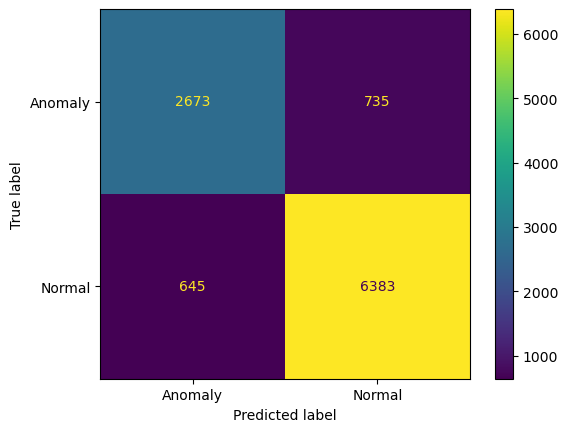

In [3]:

def complete_anomaly_detection_system():
    
    # Load data from a CSV file   
    data = pd.read_csv('US_Util_2020.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    
    data = data.drop(['zip'], axis=1)
    
#     data.info()
    X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['res_rate']
    
    data = data.dropna(axis=0, inplace=True)

    y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
    
    selector = SelectKBest(f_classif, k=4)
    X_selected = selector.fit_transform(X, y)
    
    # Sparse Autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32  # You can adjust the encoding dimension as needed
    input_data = Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_data)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder_model = Model(input_data, decoded)
    autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder_model.fit(X_selected, X_selected, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    # Get the encoded representation of the data
    encoded_data = autoencoder_model.predict(X_selected)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42)
    
    # Scale the features to [0, 1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
        # Train SVM on the training data
    svm = SVC(kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
    svm.fit(X_scaled, y_train)
    svm_predictions_train = svm.predict(X_scaled)
    svm_predictions_test = svm.predict(X_test_scaled)

    # Enhance the dataset with SVM outcomes
    X_train_enhanced = np.hstack((X_train, svm_predictions_train.reshape(-1, 1)))
    X_test_enhanced = np.hstack((X_test, svm_predictions_test.reshape(-1, 1)))

    # Filter only rows SVM detected as normal (label '1')
    normal_indices_train = svm_predictions_train == 1
    X_train_filtered = X_train_enhanced[normal_indices_train]
    y_train_filtered = y_train[normal_indices_train]

    # Train Isolation Forest on filtered normal data
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_filtered, y_train_filtered)
    if_predictions = iso_forest.predict(X_test_enhanced)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Align with binary labels
    
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    print(classification_report(y_test, if_predictions))
    

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


complete_anomaly_detection_system()